In [1]:
# The code in this cell comes from Caspar Greeven at SURFsara 

# Collected job data from Lisa using the following command:
# sacct -a --starttime 2020-01-01 --format=jobid,gid,uid,partition,submit,start,end,elapsedraw,cputimeraw,ncpus,nnodes,nodelist,exitcode,state,timelimit > $HOME/jobdata.csv

# Required packages for processing
import os
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import time, datetime, pytz
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, NullFormatter, ScalarFormatter
from datetime import date, datetime, time
import calendar
from multiprocessing import cpu_count
from pandarallel import pandarallel

%matplotlib inline

In [2]:
# The code in this cell comes from Caspar Greeven at SURFsara 

# Required preprocessing/parsing of the job data
def preprocess_jobdata_to_df(name):
    with open(os.path.join(location_job_data_csv, name),'r') as file:
        filedata = file.read()
        filedata = filedata.replace('None assigned','NoneAssigned')
    with open(os.path.join(location_job_data_csv, str('processed_'+name)),'w') as file:
        file.write(filedata)
    jobdata = pd.read_fwf(os.path.join(location_job_data_csv, str('processed_'+name)), delimiter=r"\s+", header=None)#, low_memory=False)
    jobdata = jobdata.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    jobdata = jobdata.rename(columns=jobdata.iloc[0]).drop(jobdata.index[0])
    jobdata = jobdata.iloc[1:]
    jobdata = jobdata.astype({"ElapsedRaw": int, "CPUTimeRAW": int, "NCPUS": int})
    return(jobdata)

In [3]:
location_job_data_csv = "path/to/surfsara-jobdata/"
jobdata = preprocess_jobdata_to_df("jobdata.csv")


In [4]:
# The code in this cell comes from Caspar Greeven at SURFsara 

# Some extra preprocessing required for the job data, e.g. filtering out irrelevant login nodes
filtered_jobs = jobdata[(jobdata["Start"] >= '2019-12-29 23:00:00') & (jobdata["Start"] <= '2020-08-07 21:59:45')]
filtered_jobs = filtered_jobs[(~filtered_jobs["NodeList"].str.contains("None")) & (~filtered_jobs["NodeList"].str.contains("software")) & (~filtered_jobs["NodeList"].str.contains("login"))]

In [5]:
filtered_jobs["dt"] = pd.to_datetime(filtered_jobs['Submit'], utc=False, format="%Y-%m-%dT%H:%M:%S")
filtered_jobs["submit_hour_of_day"] = filtered_jobs["dt"].dt.hour
filtered_jobs["submit_day_of_week"] = filtered_jobs["dt"].apply(lambda x : x.weekday())
filtered_jobs["submit_date"] = filtered_jobs["dt"].dt.date


In [10]:
# Creates a column that indicates if a job was executed on ML nodes 
gpu_nodes = {
    "r28n1", "r28n2", "r28n3", "r28n4", "r28n5",
    "r29n1", "r29n2", "r29n3", "r29n4", "r29n5",
    "r30n1", "r30n2", "r30n3", "r30n4", "r30n5", "r30n6", "r30n7",
    "r31n1", "r31n2", "r31n3", "r31n4", "r31n5", "r31n6"
    "r32n1", "r32n2", "r32n3", "r32n4", "r32n5", "r32n6", "r32n7",
    "r33n2", "r33n3", "r33n5", "r33n6",
    "r34n1", "r34n2", "r34n3", "r34n4", "r34n5", "r34n6", "r34n7",
    "r35n1", "r35n2", "r35n3", "r35n4", "r35n5",
    "r36n1", "r36n2", "r36n3", "r36n4", "r36n5",
    "r38n1", "r38n2", "r38n3", "r38n4", "r38n5",
}

def split_nodes(s): # parses node strings like r12n[1-30,32] to r12n1, r12n2 ... r12n30, r12n32
    if s is None or len(s) == 0:
        return set()
    
    s = s.replace("\r\n", "").replace("\n", "").replace("\t", "")

    start = 0
    index = 0
    rack_chunks = []
    in_bracket = False
    while index < len(s):  # Separate them in parts like r12n[1-30,32] or r13n1
        if s[index] == "[":
            in_bracket = True
        elif s[index] == "]":
            in_bracket = False
        elif s[index] == "," and not in_bracket:
            rack_chunks.append(s[start: index])
            start = index + 1
        index += 1
    rack_chunks.append(s[start: index])  # Add the last line
    
    node_names = set()

    for rack_chunk in rack_chunks:
        if "[" in rack_chunk:
            prefix, postfix = rack_chunk.split("[")
            postfix = postfix[:-1]  # Remove the last bracket
            nodes = postfix.split(",")
            for node in nodes:
                if "-" in node:
                    start, end = node.split("-")
                    if not start.isnumeric() or not end.isnumeric():
                        continue
                    for i in range(int(start), int(end) + 1):
                        node_names.add("{}{}".format(prefix, i))
                else:
                    node_names.add("{}{}".format(prefix, node))
        else:
            node_names.add(rack_chunk)

    return node_names

def calculate_perjob(row):
    nodes = row["NodeList"]
    splitnodes = split_nodes(nodes)
    return any([n in gpu_nodes for n in splitnodes])

pandarallel.initialize(nb_workers=min(cpu_count(), 8), progress_bar=True)
filtered_jobs["is_gpu"] =  filtered_jobs.parallel_apply(calculate_perjob, axis=1)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
std_per_hour = filtered_jobs.value_counts(["submit_date", "submit_hour_of_day"], sort=False).groupby("submit_hour_of_day").std()
x_vals = np.arange(filtered_jobs["submit_hour_of_day"].nunique())
y_vals = filtered_jobs.value_counts(["submit_date", "submit_hour_of_day"], sort=False).groupby("submit_hour_of_day").mean()

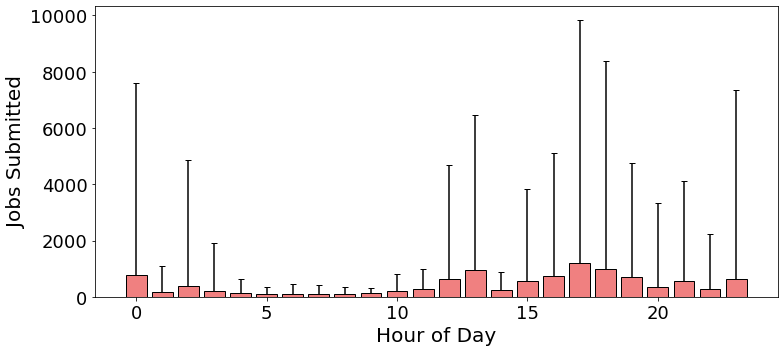

In [9]:
fig, ax = plt.subplots(figsize=(11,5))
negative_direction_values = np.zeros(len(std_per_hour))  # We create a 2d array to make sure matplotlib does not create downwards errorbars
ax.bar(x_vals, y_vals, yerr=[negative_direction_values, std_per_hour], color="lightcoral", edgecolor='black', capsize=3)

ax.set_ylim(bottom=0, top=None)
ax.set_xlabel("Hour of Day", fontsize=20)
ax.set_ylabel("Jobs Submitted", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

fig.savefig(f"num_jobs_diurnal_hourly_{date_time}.pdf")

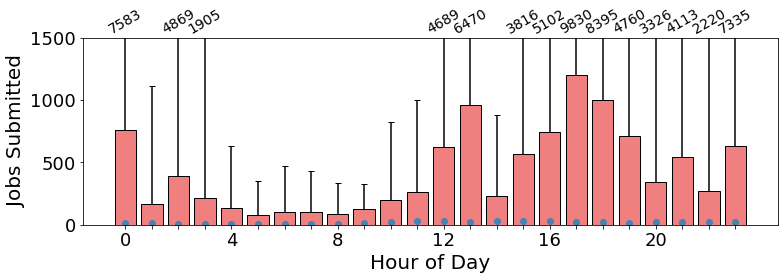

In [11]:
# Cropped version of the plot above
fig, ax = plt.subplots(figsize=(11,4))
negative_direction_values = np.zeros(len(std_per_hour))  # We create a 2d array to make sure matplotlib does not create downwards errorbars
ax.bar(x_vals, y_vals, yerr=[negative_direction_values, std_per_hour], color="lightcoral", edgecolor='black', capsize=3)

threshold = 1500
ax.set_ylim(bottom=0, top=threshold)
ax.set_xticks(range(0,24))
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
ax.set_xlabel("Hour of Day", fontsize=20)
ax.set_ylabel("Jobs Submitted", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

scatter_x = []
scatter_y = []
for x_val, y_val, std_val in zip(x_vals, y_vals, std_per_hour):
    if y_val+std_val > threshold:
        scatter_x.append(x_val)
        scatter_y.append(y_val + std_val)

index = 0
for scat_x, scat_y in zip(scatter_x, scatter_y):
    ax.text(x=scat_x, y=threshold * 1.02, s=int(round(scat_y, 0)), fontsize=14, ha='center', rotation=30)
    index += 1

# Annotate the mean for ML jobs
x_vals_ml = np.arange(filtered_jobs[filtered_jobs['is_gpu'] == True]["submit_hour_of_day"].nunique())
y_vals_ml = filtered_jobs[filtered_jobs['is_gpu'] == True].value_counts(["submit_date", "submit_hour_of_day"], sort=False).groupby("submit_hour_of_day").mean()
ax.scatter(x_vals_ml, y_vals_ml, marker='o', c="steelblue", alpha=1, zorder=2)

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.tight_layout()
fig.savefig(f"num_jobs_diurnal_hourly_cropped_ml_mean_{date_time}.pdf")

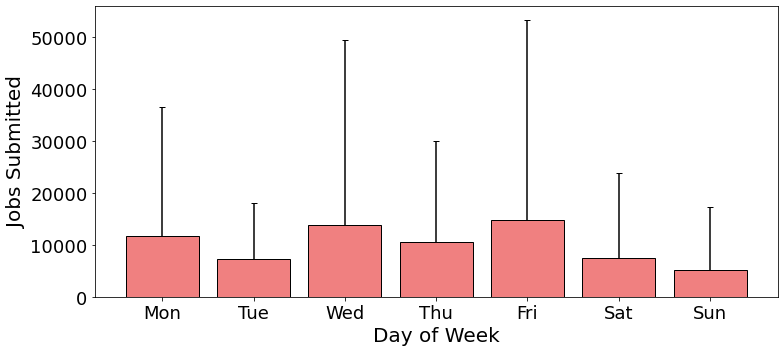

In [6]:
std_per_day_of_week = filtered_jobs.value_counts(["submit_date", "submit_day_of_week"], sort=False).groupby("submit_day_of_week").std()
x_vals = np.arange(filtered_jobs["submit_day_of_week"].nunique())
y_vals = filtered_jobs.value_counts(["submit_date", "submit_day_of_week"], sort=False).groupby("submit_day_of_week").mean()

fig, ax = plt.subplots(figsize=(11,5))
negative_direction_values = np.zeros(len(std_per_day_of_week))  # We create a 2d array to make sure matplotlib does not create downwards errorbars
ax.bar(x_vals, y_vals, yerr=[negative_direction_values, std_per_day_of_week], color="lightcoral", edgecolor='black', capsize=3)

# ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=None)
ax.set_xlabel("Day of Week", fontsize=20)
ax.set_ylabel("Jobs Submitted", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

def get_converted_xticks(ax):
    days_of_week =dict(enumerate(calendar.day_abbr))
    return [days_of_week[tick] for tick in ax.get_xticks()]  # Get the hour number

ax.set_xticks(x_vals)
ax.set_xticklabels(get_converted_xticks(ax))
fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"num_jobs_day_of_week_{date_time}.pdf")

In [8]:
y_vals = filtered_jobs.value_counts(["submit_date", "submit_day_of_week"], sort=False).groupby("submit_day_of_week").mean()
y_vals.max() / y_vals.min()
print(y_vals)

submit_day_of_week
0    11610.187500
1     7191.406250
2    13880.093750
3    10471.500000
4    14753.906250
5     7429.193548
6     5160.156250
dtype: float64


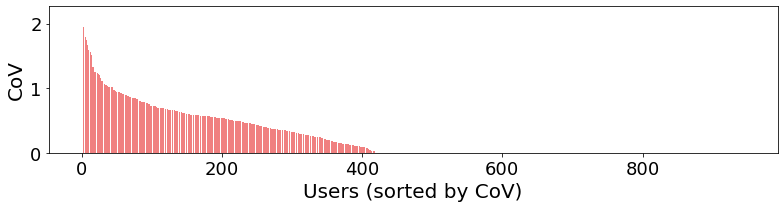

In [11]:
# This cell prints the (sorted) CoV in number of CPUs (cores) requested per user
data = filtered_jobs[["UID", "NCPUS"]].groupby(["UID"]).std() / filtered_jobs[["UID", "NCPUS"]].groupby(["UID"]).mean()
data.sort_values("NCPUS", ascending=False, inplace=True)

x_vals = np.arange(len(data))
y_vals = data["NCPUS"]
fig, ax = plt.subplots(figsize=(11,3))
ax.bar(x_vals, y_vals, color="lightcoral")

ax.set_xlabel("Users (sorted by CoV)", fontsize=20)
ax.set_ylabel("CoV", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"cov_cpus_requested_per_user_{date_time}.pdf")

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


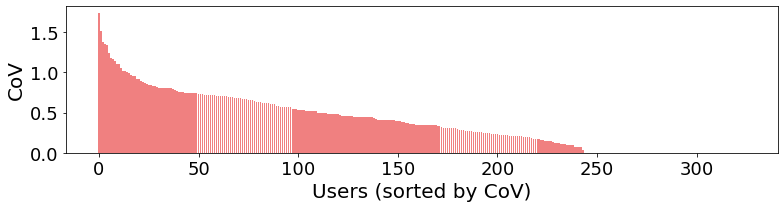

In [11]:
data = filtered_jobs[filtered_jobs['is_gpu'] == True][["UID", "NCPUS"]].groupby(["UID"]).std() / filtered_jobs[filtered_jobs['is_gpu'] == True][["UID", "NCPUS"]].groupby(["UID"]).mean()
data.sort_values("NCPUS", ascending=False, inplace=True)

x_vals = np.arange(len(data))
y_vals = data["NCPUS"]
fig, ax = plt.subplots(figsize=(11,3))
ax.bar(x_vals, y_vals, color="lightcoral")

ax.set_xlabel("Users (sorted by CoV)", fontsize=20)
ax.set_ylabel("CoV", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"cov_cpus_requested_per_user_ml_jobs{date_time}.pdf")

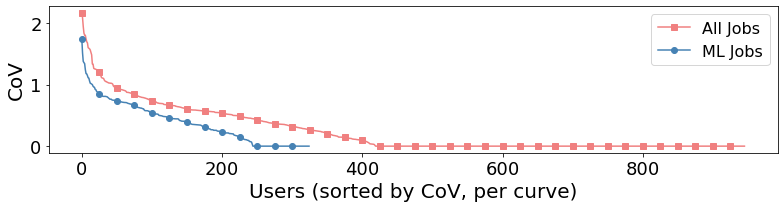

In [58]:
# This cell prints the (sorted) CoV in number of CPUs (cores) requested per user in general and for ML jobs in a curve plot

data = filtered_jobs[["UID", "NCPUS"]].groupby(["UID"]).std() / filtered_jobs[["UID", "NCPUS"]].groupby(["UID"]).mean()
data.sort_values("NCPUS", ascending=False, inplace=True)

x_vals = np.arange(len(data))
y_vals = data["NCPUS"]
fig, ax = plt.subplots(figsize=(11,3))
ax.plot(x_vals, y_vals, color="lightcoral", label="All Jobs", marker="s", markevery=25, markersize=6)

data = filtered_jobs[filtered_jobs['is_gpu'] == True][["UID", "NCPUS"]].groupby(["UID"]).std() / filtered_jobs[filtered_jobs['is_gpu'] == True][["UID", "NCPUS"]].groupby(["UID"]).mean()
data.sort_values("NCPUS", ascending=False, inplace=True)

x_vals = np.arange(len(data))
y_vals = data["NCPUS"]

ax.plot(x_vals, y_vals, color="steelblue", label="ML Jobs", marker="o", markevery=25, markersize=6)

ax.set_xlabel("Users (sorted by CoV, per curve)", fontsize=20)
ax.set_ylabel("CoV", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.legend(prop={"size": 16})
fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"cov_cpus_requested_per_user_line_{date_time}.pdf")

In [6]:
# This cell outputs the total fraction of jobs per state

state_counts_fraction = filtered_jobs["State"].value_counts() / len(filtered_jobs)
state_counts_fraction.rename({"OUT_OF_ME": "OUT OF MEMORY", "NODE_FAIL": "NODE FAILURE"}, inplace=True)

print(r"""\begin{table}[] % Made by running job_arrival_characterization.ipynb
\caption{Fraction of jobs per job state in Lisa}
\label{surfing:tbl:job-state-fraction}
\adjustbox{width=\linewidth}{
\begin{tabular}{@{}llllllllll@{}}""")
print(" & ".join(state_counts_fraction.index))
print(" & ".join(["{:.6f}".format(i) for i in state_counts_fraction.values]))
print(r"""\end{tabular}
}
\end{table}""")

\begin{table}[] % Made by running job_arrival_characterization.ipynb
\caption{Fraction of jobs per job state in Lisa}
\label{surfing:tbl:job-state-fraction}
\adjustbox{width=\linewidth}{
\begin{tabular}{@{}llllllllll@{}}
COMPLETED & FAILED & CANCELLED & TIMEOUT & OUT OF MEMORY & REQUEUED & NODE FAILURE
0.916742 & 0.060288 & 0.011632 & 0.010783 & 0.000544 & 0.000007 & 0.000003
\end{tabular}
}
\end{table}


               completed  cancelled     failed  out_of_memory  node_fail  \
type                                                                       
$<$5 minutes    20906469     941884    2279845            0.0        0.0   
$<$1 hour      188182872   10718515   10815368            0.0     4970.0   
$<$6 hours     552998001   40811256   40014691            0.0        0.0   
$<$1 day       771351584  135774303   66325910            0.0        0.0   
$\geq$1 day   1390810962  200480045  165246396            0.0  1050672.0   

                 timeout  
type                      
$<$5 minutes       93846  
$<$1 hour        5603816  
$<$6 hours      60027569  
$<$1 day       172581325  
$\geq$1 day   1078554531  


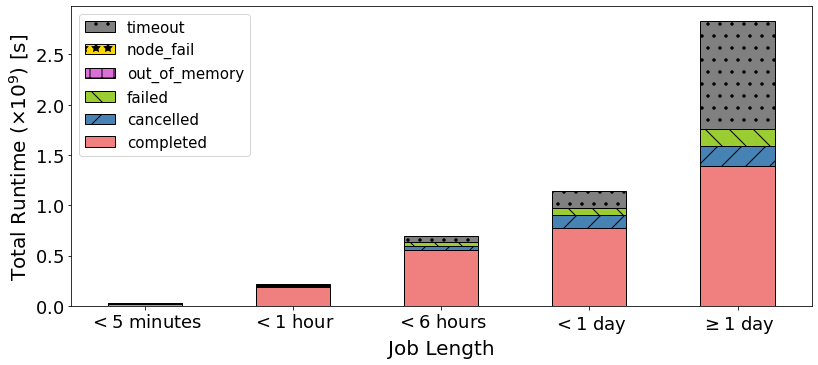

In [6]:
# Kristian's stacked barplot - largely based on his code
def jobType(x):
    if(x < 300):
        return '$<$5 minutes'
    elif(x < 3600):
        return '$<$1 hour'
    elif(x < 21600):
        return '$<$6 hours'
    elif (x < 86100):
        return '$<$1 day'
    else:
        return '$\geq$1 day'

def parsedfsum(df, arg):
    retdf = df[df['State'] == arg]
    retdf = retdf[['ElapsedRaw']]
    retdf['type'] = retdf['ElapsedRaw'].apply(lambda x: jobType(x))
    retdf = retdf.groupby('type').sum()
    retdf.columns = [arg.lower()]
    return retdf

completed = parsedfsum(filtered_jobs, 'COMPLETED')
cancelled = parsedfsum(filtered_jobs, 'CANCELLED')
failed = parsedfsum(filtered_jobs, 'FAILED')
oom = parsedfsum(filtered_jobs, 'OUT_OF_MEMORY')
nodefail = parsedfsum(filtered_jobs, 'NODE_FAIL')
timeout = parsedfsum(filtered_jobs, 'TIMEOUT')


merged = pd.concat([completed,cancelled,failed,oom,nodefail,timeout], axis=1).sort_values('completed', ascending=True)
merged.fillna(0, inplace=True)
print(merged)

colors = ["lightcoral", "steelblue", "yellowgreen", "orchid", "gold", "gray"]
hatches = ['', '/', '\\', '+', '*', '.']


fig, ax = plt.subplots(figsize=(11,5))
ax = merged.plot.bar(stacked=True,
                     fontsize=14,
                     ax=ax,
                     color=colors,
                     edgecolor="black",
                    )


# Add the patterns, based on https://stackoverflow.com/a/22836353
bars = ax.patches
for num, bar in enumerate(bars):
    bar.set_hatch(hatches[int(num / merged.index.nunique())])

ax.get_yaxis().set_major_formatter(ScalarFormatter(useMathText=True)) 
ax.set_xticklabels(labels=merged.index, rotation=0)
ax.yaxis.get_offset_text().set_visible(False)

fig.tight_layout()  # This forces matplotlib to compute the offset label, which otherwise will be empty. Has no impact on the figure.

ax.set_xlabel('Job Length', fontsize=20)
ax.set_ylabel("Total Runtime ({}) [s]".format(ax.get_yaxis().get_major_formatter().get_offset()), fontsize=20)  # Based on https://stackoverflow.com/a/45766598
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], prop={"size": 15})

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"runtime_per_state_grouped_job_runtime_{date_time}.pdf", bbox_inches='tight')

In [12]:
# Run this once for the next cell
def jobType(row):
    x = row['elapsedraw']
    if(x < 300):
        return '$<$5 minutes'
    elif(x < 3600):
        return '$<$1 hour'
    elif(x < 21600):
        return '$<$6 hours'
    elif (x < 86100):
        return '$<$1 day'
    else:
        return '$\geq$1 day'


plot_df = filtered_jobs.copy()
plot_df = plot_df[plot_df['State'].isin(['COMPLETED', 'CANCELLED', 'FAILED', 'OUT_OF_ME', 'NODE_FAIL', 'TIMEOUT'])]
plot_df.columns = [col.lower() for col in plot_df.columns]
plot_df['group_runtime'] = plot_df.apply(jobType, axis=1)
plot_df.fillna(0, inplace=True)

group_runtime
$<$5 minutes    0.137867
$<$1 hour       0.128716
$<$6 hours      0.205573
$<$1 day        0.331014
$\geq$1 day     0.512334
dtype: float64
group_runtime
$<$5 minutes    0.519284
$<$1 hour       0.396604
$<$6 hours      0.323560
$<$1 day        0.469558
$\geq$1 day     0.558288
dtype: float64


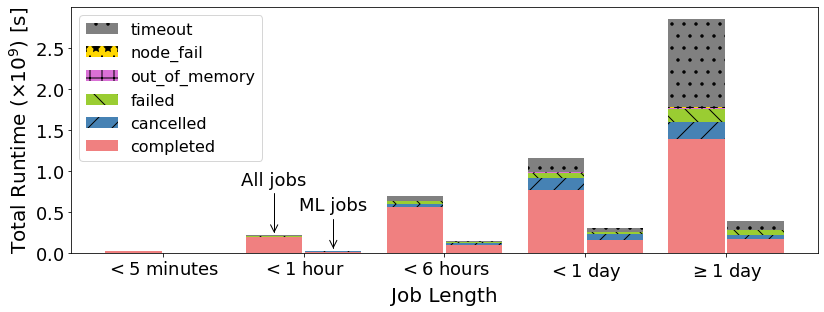

In [21]:
# Kristian's stacked barplot - largely based on his code
colors = ["lightcoral", "steelblue", "yellowgreen", "orchid", "gold", "gray"]
hatches = ['', '/', '\\', '+', '*', '.']


fig, ax = plt.subplots(figsize=(11,4))

# Plot the general bars:
bar_width = 0.4
offset = [-0.21, .21]

sub_df = plot_df[['group_runtime', 'state', 'elapsedraw']].groupby(["group_runtime", "state"]).sum().unstack(level=1).fillna(0)
sub_df.columns = [col.lower() for col in sub_df.columns.droplevel(0)]
sub_df.rename(columns={"out_of_me": "out_of_memory"}, inplace=True)
sub_df = sub_df[['completed', 'cancelled', 'failed', 'out_of_memory', 'node_fail', 'timeout']]
sub_df = sub_df.sort_values('completed', ascending=True)

print(1 - (sub_df['completed'] / sub_df.sum(axis=1)))

for x_pos, group in enumerate(sub_df.index):
    bottom = 0
    for index, col in enumerate(sub_df.columns):
        ax.bar(x_pos + offset[0], sub_df.loc[group].iloc[index],  bottom=bottom, label=col, color=colors[index], hatch=hatches[index], width=bar_width)
        bottom += sub_df.loc[group].iloc[index]
        
ax.annotate("All jobs",
            xy=(1 + offset[0], sub_df.iloc[1].sum()), xycoords='data',
            xytext=(0, 50), textcoords='offset points',
            fontsize=18, color="black", ha='center',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc",
                            color="black"
                           )
            )

sub_df = plot_df[plot_df['is_gpu'] == True][['group_runtime', 'state', 'elapsedraw']].groupby(["group_runtime", "state"]).sum().unstack(level=1).fillna(0)
sub_df.columns = [col.lower() for col in sub_df.columns.droplevel(0)]
sub_df.rename(columns={"out_of_me": "out_of_memory"}, inplace=True)
sub_df = sub_df[['completed', 'cancelled', 'failed', 'out_of_memory', 'node_fail', 'timeout']]
sub_df = sub_df.sort_values('completed', ascending=True)

ax.set_xticks(range(len(sub_df.index)))
ax.set_xticklabels(labels=sub_df.index, rotation=0)

print(1 - (sub_df['completed'] / sub_df.sum(axis=1)))

for x_pos, group in enumerate(sub_df.index):
    bottom = 0
    for index, col in enumerate(sub_df.columns):
        ax.bar(x_pos + offset[1], sub_df.loc[group].iloc[index],  bottom=bottom, label=col, color=colors[index], hatch=hatches[index], width=bar_width)
        bottom += sub_df.loc[group].iloc[index]

ax.annotate("ML jobs",
            xy=(1 + offset[1], sub_df.iloc[1].sum()), xycoords='data',
            xytext=(0, 40), textcoords='offset points',
            fontsize=18, color="black", ha='center',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc",
                            color="black"
                           )
            )

ax.get_yaxis().set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_offset_text().set_visible(False)

fig.tight_layout()  # This forces matplotlib to compute the offset label, which otherwise will be empty. Has no impact on the figure.

ax.set_xlabel('Job Length', fontsize=20)
ax.set_ylabel("Total Runtime ({}) [s]".format(ax.get_yaxis().get_major_formatter().get_offset()), fontsize=20)  # Based on https://stackoverflow.com/a/45766598
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(prop={"size": 16})

# Filter duplicate labels see https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(list(by_label.values())[::-1], list(by_label.keys())[::-1], prop={"size": 16})

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"runtime_per_state_grouped_job_runtime_all_vs_ml_{date_time}.pdf", bbox_inches='tight')